# Word frequencies in digitised journals

This notebook uses word frequency to explore the [OCRd texts harvested](Download-text-for-all-digitised-journals.ipynb) from Trove's digitised journals. More documentation coming...

In [1]:
import re
import tarfile
import zipfile
from io import BytesIO
import pandas as pd
import requests
from tqdm.auto import tqdm
import altair as alt
import os
from pathlib import Path
import ipywidgets as widgets
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np


## Select a journal

Create a dropdown widget to select a digitised journal. The cells below will use this widget to get the value of the currently selected journal.

In [2]:
# Load details of digitised journals from CSV
df_journals = pd.read_csv('digital-journals-with-text.csv').sort_values(by='title')
journal_list = [(f"{j['title']} ({j['issues_with_text']} issues)", j['directory']) for j in df_journals[['title', 'directory', 'issues_with_text']].to_dict('records')]
journals = widgets.Dropdown(options=journal_list, disabled=False)
display(journals)

Dropdown(options=(('"Coo-ee!" (Bishops Knoll Hospital (Bristol, England)) (12 issues)', 'coo-ee-bishops-knoll-…

## Download all the issues of the journal

In [ ]:
def download_journal(journal):
    path = os.path.join('downloads', journal)
    os.makedirs(path, exist_ok=True)
    params = {
        'path': f'/{journal}/texts'
    }
    response = requests.get('https://cloudstor.aarnet.edu.au/plus/s/QOmnqpGQCNCSC2h/download', params=params)
    zipped = zipfile.ZipFile(BytesIO(response.content))
    zipped.extractall(path)
    print(f'{len(get_docs_path(journal))} issues downloaded')

In [ ]:
download_journal(journals.value)

## Calculate word frequencies

In [3]:
def get_docs(journal):
    docs_path = get_docs_path(journal)
    for p in docs_path:
        yield p.read_text(encoding='utf-8').strip()
        
def get_docs_path(journal):
    path = os.path.join('downloads', journal, 'texts')
    docs_path = [p for p in sorted(Path(path).glob('*.txt'))]
    return docs_path

def get_file_names(journal):
    return [p.stem for p in get_docs_path(journal)]

In [4]:
vectorizer = CountVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2))
# preprocessor = lambda x: re.sub(r'(\d[\d\.])+', 'NUM', x.lower())
X_freq = np.asarray(vectorizer.fit_transform(get_docs(journals.value)).todense())
df_freq = pd.DataFrame(X_freq, columns=vectorizer.get_feature_names(), index=get_file_names(journals.value))

In [ ]:
# Save to CSV
# df_freq.to_csv(f'{journals.value}-word-frequencies.csv')

## Most frequent words in the journal

Change the number as you wish.

In [5]:
df_freq.sum().nlargest(20)

little    21967
said      21665
day       13243
like      12804
came      10828
come      10615
time      10419
man       10257
great      9875
old        9532
did        8798
away       8644
long       8485
went       8445
good       8131
men        7621
just       7506
way        7433
king       7336
water      6730
dtype: int64

## Frequency of a specific word

In [6]:
word = 'captain cook'

In [7]:
# If the word's not in the index you'll get a KeyError -- don't worry about it, just try another word!!
df_freq[word].sum()

305

Find the issue that this word occurs in most frequently.

In [8]:
df_freq[word].idxmax()

'the-school-magazine-of-literature-for-our-boys-and-vol-24-no-9-part-2-class-4-october-2-1939-nla.obj-774980753'

## Most frequent words per issue

Get the most frequent words for each issue of the journal. Set `num_words` to the number of words you want to show.

In [9]:
# The number of words you want to show
num_words = 20
top_words = pd.DataFrame({n: df_freq.T[col].nlargest(num_words).index.tolist() for n, col in enumerate(df_freq.T)}).T
top_words.index = get_file_names(journals.value)
top_words.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
no-title-available-vol-33-no-8-part-3-class-5-september-3-1947-nla.obj-831180245,said,alice,like,neck,hatter,prince,time,gay,gay neck,dormouse,march,baz,hare,march hare,flock,ll,walrus,know,old,black
the-school-magazine-of-literature-for-our-boys-and-150th-anniversary-celebrations-on-the-founding-of--nla.obj-774678501,australian,royal,society,royal australian,data,historical,historical society,australian historical,data royal,picture,australia,courtesy,south,sydney,new,society picture,captain,bay,cook,port
the-school-magazine-of-literature-for-our-boys-and-souvenir-of-children-s-festival-coronation-celebra-nla.obj-774657223,king,empire,coronation,great,queen,day,children,love,new,new south,south,south wales,wales,british,girls,loyalty,gracious,hearts,long,thy
the-school-magazine-of-literature-for-our-boys-and-vol-1-no-1-part-1-class-3-february-1-1916-nla.obj-770389941,little,jack,said,giant,mother,blackie,away,day,came,flower,flowers,saw,house,mouse,soon,stalk,time,wife,friend,garden
the-school-magazine-of-literature-for-our-boys-and-vol-1-no-1-part-2-classes-4-5-february-2-1916-nla.obj-770389964,44,betty,earl,said,time,great,jack,king,11,good,little,came,flag,home,know,old,did,like,way,boys


Get the top words for a specific issue.

In [ ]:
top_words.loc[top_words.index.str.contains('nla.obj-774168904')]

## Track word frequencies over time

In [10]:
def extract_year(name):
    '''
    Try to extract the year from the filename.
    '''
    try:
        years = re.findall(r'-((?:18|19|20)\d{2})-', name)
        year = int(years[-1])
    except IndexError:
        year = 0
        print(f'YEAR NOT FOUND: {name}')
    return year
    
df_freq['year'] = df_freq.apply(lambda x: extract_year(x.name), axis=1)

YEAR NOT FOUND: the-school-magazine-of-literature-for-our-boys-and-150th-anniversary-celebrations-on-the-founding-of--nla.obj-774678501
YEAR NOT FOUND: the-school-magazine-of-literature-for-our-boys-and-souvenir-of-children-s-festival-coronation-celebra-nla.obj-774657223


In [11]:
# Top words per year
year_groups = df_freq.groupby(by='year')
year_group_totals = year_groups.sum()
df_years = pd.DataFrame({n: year_group_totals.T[col].nlargest(10).index.tolist() for n, col in enumerate(year_group_totals.T)}).T
df_years.index = [name for name, _ in year_groups]
df_years.head()

,0,1,2,3,4,5,6,7,8,9
0,australian,royal,society,royal australian,data,historical,historical society,australian historical,data royal,australia
1916,little,said,44,time,great,day,came,like,king,did
1917,little,said,day,great,came,man,men,king,old,away
1918,said,little,day,time,great,came,mother,man,alice,like
1919,said,little,day,men,man,like,time,came,king,good


In [12]:
def words_by_year(df, words):
    df_words = pd.DataFrame()
    for word in words:
        try:
            df_word = df.groupby(by='year').sum()[word].to_frame().reset_index().rename({word: 'count'}, axis=1)
        except KeyError:
            print(f"'{word}' not found")
        else:
            df_word['word'] = word
            df_words = df_words.append(df_word, ignore_index=True)
    return df_words

Make a list of words that we want to compare.

In [ ]:
words = ['queen', 'captain cook', 'chinese', 'kangaroo']

Get the data for those words.

In [17]:
df_words = words_by_year(df_freq, words)

Create a faceted line chart.

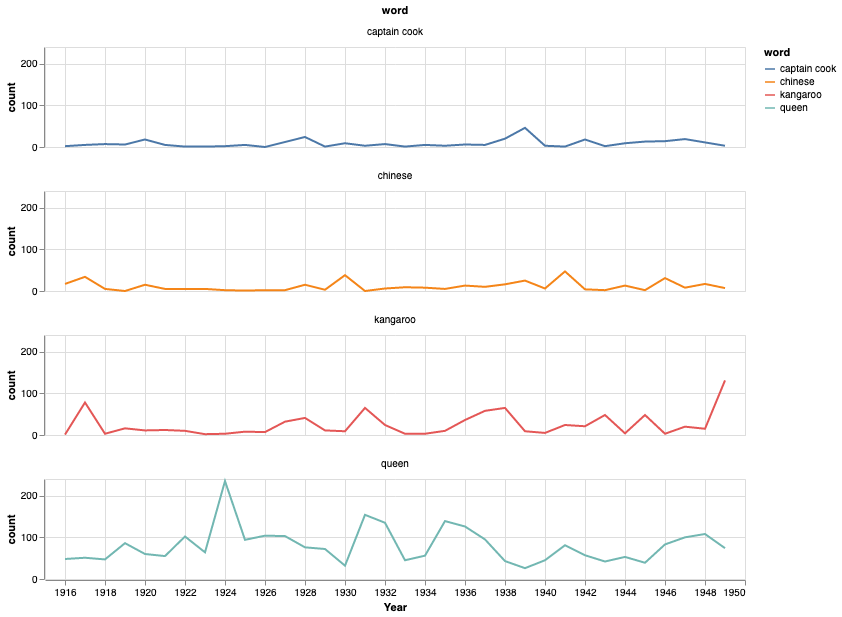

In [18]:
alt.Chart(df_words.loc[df_words['year'] > 0]).mark_line().encode(
    x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year')),
    y='count:Q',
    color='word:N',
    facet='word:N'
).properties(width=700, height=100, columns=1)

Or perhaps you prefer bubblelines.

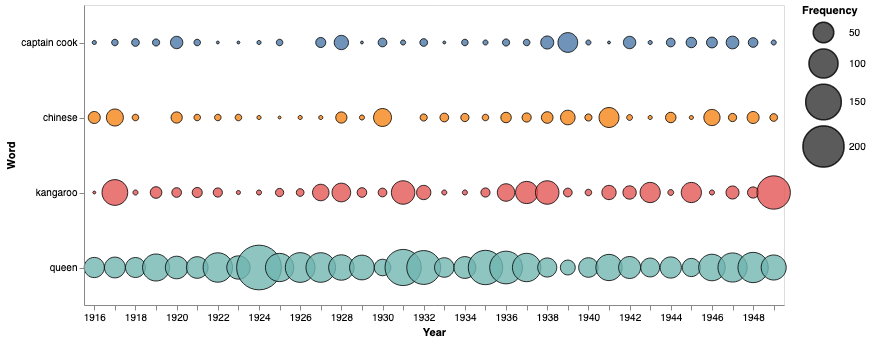

In [19]:
# Create a chart
alt.Chart(df_words.loc[df_words['year'] > 0]).mark_circle(
    
    # Style the circles
    opacity=0.8,
    stroke='black',
    strokeWidth=1
).encode(
    
    # Year on the X axis
    x=alt.X('year:O', axis=alt.Axis(format='c', title='Year', labelAngle=0)),
    
    # Object type on the Y axis
    y=alt.Y('word:N', title='Word'),
    
    # Size of the circles represents the number of objects
    size=alt.Size('count:Q',
        scale=alt.Scale(range=[0, 2000]),
        legend=alt.Legend(title='Frequency')
    ),
    
    # Color the circles by object type
    color=alt.Color('word:N', legend=None),
    
    # More details on hover
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('year:O', title='Year'), alt.Tooltip('count:Q', title='Frequency', format=',')]
).properties(
    width=700,
    height=300
)